# Follow-up questions - 02/02/2022

## Table of contents

1. [Phenotypes](#Phenotypes)
    1. [Summary](#Summary-for-phenotypes)
2. [Uncertain ranges](#Uncertain-ranges)
    1. [Spans](#Uncertainty-from-spans)
    2. [Genes](#Uncertainty-from-genes)
    3. [Summary](#Summary-for-uncertainty)

In [1]:
from collections import defaultdict, Counter
from itertools import zip_longest
import json
import os
import re
import sys
import urllib

import numpy as np
import requests

from consequence_prediction.vep_mapping_pipeline.consequence_mapping import *
from eva_cttv_pipeline.clinvar_xml_io.clinvar_xml_io import *
from eva_cttv_pipeline.evidence_string_generation.clinvar_to_evidence_strings import convert_allele_origins

%matplotlib inline
import matplotlib.pyplot as plt

## Phenotypes

> What are the phenotypes of the structural variant? Are they somatic or germline?

[Top of page](#Table-of-contents)

In [2]:
PROJECT_ROOT = '/home/april/projects/opentargets/complex-events'

# dump of all records with no functional consequences and no complete coordinates
# uses June consequence pred + ClinVar 6/26/2021
no_consequences_path = os.path.join(PROJECT_ROOT, 'no-conseq_no-coords.xml.gz')
dataset = ClinVarDataset(no_consequences_path)

In [3]:
def get_somatic_germline_counts(dataset):
    all_allele_origins = [convert_allele_origins(record.valid_allele_origins) for record in dataset]
    
    # Our pipeline's definition for distinguishing somatic & germline
    def is_somatic(allele_origins):
        return allele_origins == ['somatic']

    phenotypes_counts = Counter()
    for allele_origins in all_allele_origins:
        germline = False
        somatic = False
        for ao in allele_origins:
            if is_somatic(ao):
                somatic = True
            else:
                germline = True
        if germline and somatic:
            phenotypes_counts['both'] += 1
        if germline and not somatic:
            phenotypes_counts['germline'] += 1
        if somatic and not germline:
            phenotypes_counts['somatic'] += 1
            
    # flat count of allele origins
    flattened_allele_origins = [x for allele_origins in all_allele_origins for ao in allele_origins for x in ao]
    flat_pheno_counts = Counter(flattened_allele_origins)
            
    return phenotypes_counts, flat_pheno_counts

In [4]:
complex_phenotypes, complex_flat_aos = get_somatic_germline_counts(dataset)

In [5]:
complex_phenotypes

Counter({'germline': 17335, 'somatic': 313, 'both': 1})

In [6]:
# check if these are enriched in somatic relative to full set
full_dataset = ClinVarDataset(os.path.join(PROJECT_ROOT, 'ClinVarFullRelease_2021-07.xml.gz'))

In [7]:
full_phenotypes, full_flat_aos = get_somatic_germline_counts(full_dataset)

In [8]:
full_phenotypes

Counter({'germline': 1414050, 'somatic': 12528, 'both': 219})

In [9]:
def percent_somatic(c):
    return c['somatic'] / sum(c.values()) * 100.0

In [10]:
print('percent somatic for complex:', percent_somatic(complex_phenotypes))
print('percent somatic for all:', percent_somatic(full_phenotypes))

percent somatic for complex: 1.7734715847923397
percent somatic for all: 0.8780506266834034


### Summary for phenotypes

* somatic slightly enriched in complex variants compared to germline, but not much
    * complex are **1.77%** somatic (vs. **0.878%** overall)
    
[Top of page](#Table-of-contents)

## Uncertain ranges

> It would be interesting to know the size of the uncertainty when it is known and compare it to the known inner range (ratio between certain range and uncertain range).

[Top of page](#Table-of-contents)

#### Imprecise - known bounds

Ex. `NC_000011.8:g.(67967534_67967551)_(67974756_67974774)del`

"Certainty" = smallest possible span divided by largest possible span

Also interested in the absolute size of the potential deviation (range of start points + range of end points)

In [16]:
(67974756 - 67967551) / (67974774 - 67967534)

0.9951657458563536

In [17]:
# total size of range for start & stop endpoints
(67967551 - 67967534) + (67974774 - 67974756)

35

#### Precise

Ex. `NC_000016.10:g.12595039_12636793del`

Certainty of 1 (no uncertainty)

#### Imprecise - unknown bounds

Ex. `NC_000015.10:g.(?_26547773)_(26775295_?)del`

In theory we could compute the same numbers using the full length of the reference sequence, but not sure it's meaningful.

In [18]:
(26775295 - 26547773) / 101991189  # length of chr 15

0.002230800544937269

### Uncertainty from spans

For this we only include the imprecise, known bounds case.  Note numbers from [previous notebook](https://nbviewer.org/github/EBIvariation/eva-opentargets/blob/master/data-exploration/complex-events/notebooks/detailed-hgvs-stats.ipynb#Ranges)

* precise: **1735**
    * uncertainty is 0
* imprecise (known bounds): **559**
    * measures make sense, numbers below
* imprecise (unknown bounds, _mostly unknown outer bounds_): **9311**
    * measures might not make sense

[Top of page](#Table-of-contents)

In [34]:
sequence_identifier = r'[a-zA-Z0-9_.]+'
genomic_sequence = f'^({sequence_identifier}):g\.'

# only INS, DEL, DUP supported by VEP
variant_type_regex = {
    re.compile(f'{genomic_sequence}.*?del(?!ins).*?') : 'DEL',
    re.compile(f'{genomic_sequence}.*?dup.*?') : 'DUP',
    re.compile(f'{genomic_sequence}.*?(?<!del)ins.*?') : 'INS',
}

# for this we EXCLUDE unknown bounds, and capture all numeric bounds on endpoints
def_range = r'([0-9]+)_([0-9]+)'
var_range = r'\(([0-9]+)_([0-9]+)\)_\(([0-9]+)_([0-9]+)\)'
ch = r'[^?_+-]'

def_span_regex = re.compile(f'{genomic_sequence}{ch}*?{def_range}{ch}*?$')
var_span_regex = re.compile(f'{genomic_sequence}{ch}*?{var_range}{ch}*?$')

In [80]:
def endpoint_bounds(dataset, include_precise=False, limit=None):
    """Returns inner and outer bounds on endpoints (duplicating inner/outer if precise)."""
    n = 0
    all_bounds = []
    
    for record in dataset:
        if not record.measure or not record.measure.hgvs:
            continue

        hs = [h for h in record.measure.hgvs if h is not None]
        n += 1
        if limit and n > limit:
            break
            
        for h in hs:
            # NC_000011.8:g.(67967534_67967551)_(67974756_67974774)del
            var_match = var_span_regex.match(h)
            if var_match and all(var_match.group(i) for i in range(2,6)):
                # use terminology from dbVar data model
                # see https://www.ncbi.nlm.nih.gov/core/assets/dbvar/files/dbVar_VCF_Submission.pdf
                outer_start = int(var_match.group(2))
                inner_start = int(var_match.group(3))
                inner_stop = int(var_match.group(4))
                outer_stop = int(var_match.group(5))   
                all_bounds.append(((outer_start, inner_start), (inner_stop, outer_stop)))
                # presumably all hgvs expressions for one record have the same span, don't double count
                break
                
            elif include_precise:
                # NC_000016.10:g.12595039_12636793del
                def_match = def_span_regex.match(h)
                if def_match and def_match.group(2) and def_match.group(3):
                    outer_start = inner_start = int(def_match.group(2))
                    inner_stop = outer_stop = int(def_match.group(3))
                    all_bounds.append(((outer_start, inner_start), (inner_stop, outer_stop)))
                    break
                
    return all_bounds

In [81]:
all_bounds = endpoint_bounds(dataset)

In [52]:
def is_valid(bounds):
    # invalid if any range is negative
    return (bounds[0][1] >= bounds[0][0]
           and bounds[1][1] >= bounds[1][0]
           and bounds[1][0] >= bounds[0][1])


def uncertainty_ratio(bounds):
    return (bounds[1][0] - bounds[0][1]) / (bounds[1][1] - bounds[0][0])


def total_range(bounds):
    return (bounds[0][1] - bounds[0][0]) + (bounds[1][1] - bounds[1][0])

In [82]:
len(all_bounds)

559

In [83]:
all_valid_bounds = [bounds for bounds in all_bounds if is_valid(bounds)]

In [84]:
len(all_valid_bounds)

555

In [85]:
all_uncertainty_ratios = [uncertainty_ratio(bounds) for bounds in all_valid_bounds]
all_total_ranges = [total_range(bounds) for bounds in all_valid_bounds]

In [86]:
# 1.0 is the most certain
print(min(all_uncertainty_ratios))
print(max(all_uncertainty_ratios))

4.895721139723881e-05
0.9999996380644046


(array([60., 26., 17., 13.,  6.,  8.,  4.,  4.,  2.,  2.,  5.,  2.,  5.,
         0.,  3.,  5.,  5.,  5.,  3.,  1.,  5.,  2.,  1.,  1.,  2.,  0.,
         1.,  1.,  3.,  4.,  5.,  2.,  3.,  2.,  4.,  3.,  9.,  1.,  3.,
         3.,  3.,  7.,  1.,  4.,  5.,  4.,  2.,  6.,  3.,  4.,  4.,  7.,
         3.,  1.,  3.,  5.,  1.,  5.,  6.,  5.,  4.,  7.,  5.,  7.,  3.,
         4.,  6.,  7.,  8.,  5.,  5.,  0.,  6.,  2.,  5.,  5.,  4.,  3.,
         3.,  5.,  2.,  3.,  7.,  6.,  5.,  4.,  5.,  9.,  5.,  4.,  5.,
         9.,  3.,  6.,  2., 11.,  8.,  6.,  6., 45.]),
 array([4.89572114e-05, 1.00484640e-02, 2.00479708e-02, 3.00474776e-02,
        4.00469844e-02, 5.00464913e-02, 6.00459981e-02, 7.00455049e-02,
        8.00450117e-02, 9.00445185e-02, 1.00044025e-01, 1.10043532e-01,
        1.20043039e-01, 1.30042546e-01, 1.40042053e-01, 1.50041559e-01,
        1.60041066e-01, 1.70040573e-01, 1.80040080e-01, 1.90039587e-01,
        2.00039093e-01, 2.10038600e-01, 2.20038107e-01, 2.30037614e-01,
  

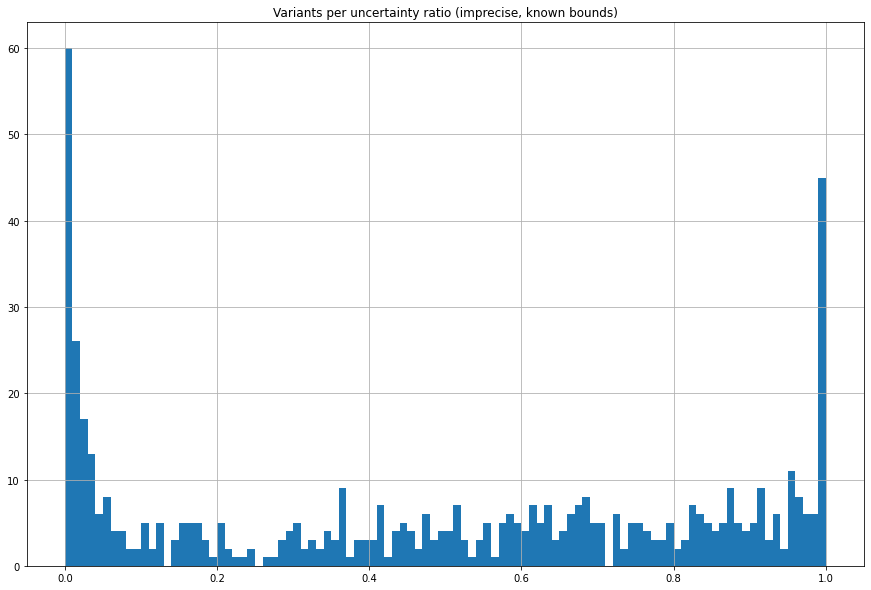

In [105]:
plt.figure(figsize=(15,10))
plt.grid(visible=True)
plt.title(f'Variants per uncertainty ratio (imprecise, known bounds)')
plt.hist(all_uncertainty_ratios, bins=100)

In [88]:
print(min(all_total_ranges))
print(max(all_total_ranges))

2
106524298


(array([462.,  39.,  16.,  16.,   8.,   2.,   5.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.00000000e+00, 7.50019700e+04, 1.50001940e+05, 2.25001910e+05,
        3.00001880e+05, 3.75001850e+05, 4.50001820e+05, 5.25001790e+05,
        6.00001760e+05, 6.75001730e+05, 7.50001700e+05, 8.25001670e+05,
        9.00001640e+05, 9.75001610e+05, 1.05000158e+06, 1.12500155e+06,
        1.20000152e+06, 1.2750

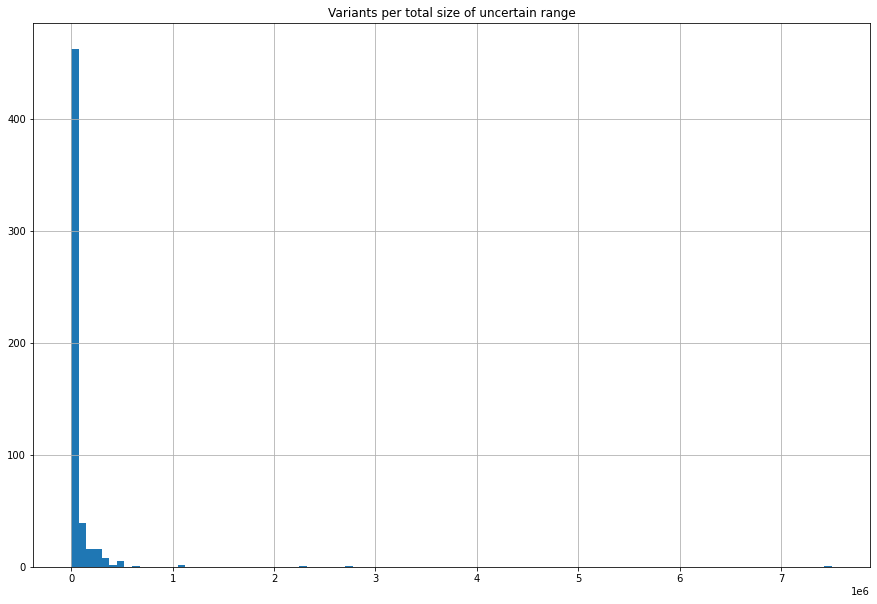

In [116]:
# exclude the max
i = all_total_ranges.index(max(all_total_ranges))

plt.figure(figsize=(15,10))
plt.grid(visible=True)
plt.title('Variants per total size of uncertain range')
plt.hist(all_total_ranges[:i] + all_total_ranges[i+1:], bins=100)

In [91]:
# the max is screwing up all my plots, get rid of it
i = all_total_ranges.index(max(all_total_ranges))

xs = all_uncertainty_ratios[:i] + all_uncertainty_ratios[i+1:]
ys = all_total_ranges[:i] + all_total_ranges[i+1:]

In [109]:
print(all_total_ranges[i])
print(all_uncertainty_ratios[i])

106524298
0.00012432237150428746


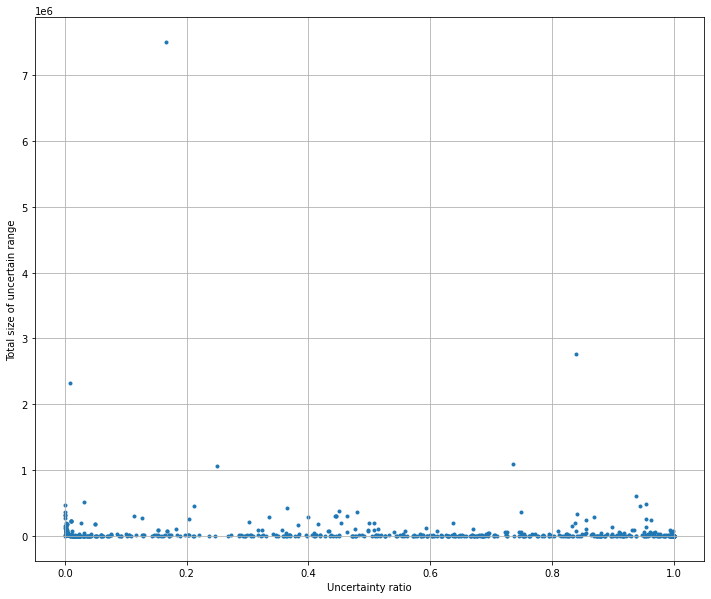

In [118]:
plt.figure(figsize=(12,10))
plt.grid(visible=True)
plt.xlabel('Uncertainty ratio')
plt.ylabel('Total size of uncertain range')
plt.scatter(xs, ys, marker='.')

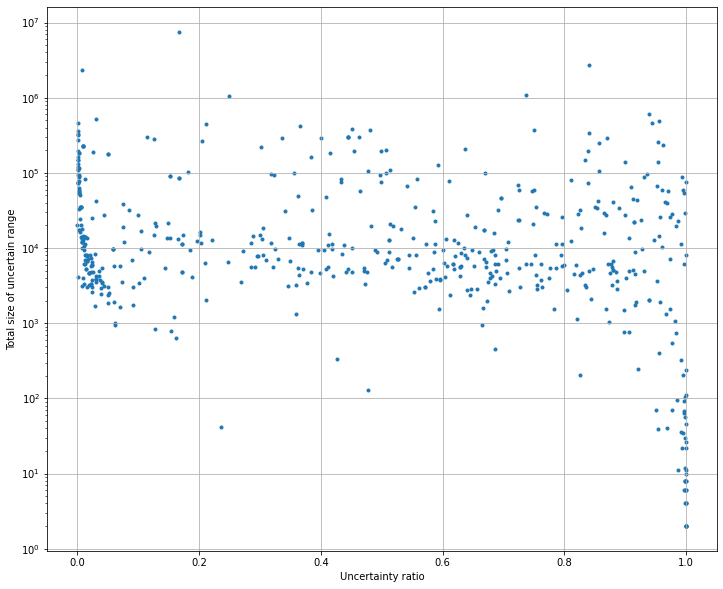

In [121]:
plt.figure(figsize=(12,10))
plt.grid(visible=True)
plt.xlabel('Uncertainty ratio')
plt.ylabel('Total size of uncertain range')
plt.yscale('log')
plt.scatter(xs, ys, marker='.')

### Uncertainty from genes

[Top of page](#Table-of-contents)

In [ ]:
# TODO - not convinced how useful this would be

### Summary for uncertainty

* a lot of variants with known bounds have a pretty small range of values their endpoints can take (i.e. 2)
    * large variance in uncertainty ratio mostly due to range of total variant size - see [previous notebook](https://nbviewer.org/github/EBIvariation/eva-opentargets/blob/master/data-exploration/complex-events/notebooks/detailed-hgvs-stats.ipynb#Span-lengths)
* computing "size" of uncertainty has limited value unless we can handle the unknown outer bounds case


#### More notes

* impact of variant type on what kinds of assertions we can make - `(?_26547773)_(26775295_?)del` vs `dup`
* expressing exactly what we know / don't know in evidence
    * we know these N genes were (partially) deleted/duplicated (\*)
    * (\*), and possibly more were also affected
    * (\*), and possibly more, but no more than __ (?)
* the known bounds case might collapse entirely to the precise case
* how this uncertainty got here (i.e. method of detection) has an impact, but we won't have that information

[Top of page](#Table-of-contents)